MH

Train neural network models (at least two different networks for each dataset, i.e., no. layers, no. neurons, activations, ...) in either Tensorflow or Pytorch to perform regression on the following datasets:

California Housing Values

In [1]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot
import numpy as np
import pandas as pd
import sklearn
import math
import glob
import os
import sys
print("imported!")

imported!


In [2]:
path = "data"

Importing:

In [3]:
with open(path + '/housing.csv', newline='') as csvfile:
    housing = pd.read_csv(csvfile)

Let's view some of the data:

In [4]:
housing.shape

(20640, 10)

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


We have to prepare the data before doing any statistical analysis on it:

First let's search for the missing values.
If the missing values are low, we can ignore them and remove them from the dataset.
Else, if they are high, we can entirely ignore the column having so many NaNs.

In [6]:
print(housing.isnull().sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


Not much, we can just remove them.

In [7]:
housing = housing.dropna(axis=0)
print(housing.isnull().sum())

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


Now we'll check for other anomalies in the data:

In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


Hmmm, it seems we have some non-numerical columns here. Let's check it out:

In [9]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: ocean_proximity, dtype: int64

Two thing to grasp here:
First, it seems more like an interval value that have been classified into several groups.
Second, we have only 5 records with the ocean_proximity attribute "ISLAND". So we might consider this as outliers and remove them.

In [10]:
# Convert type from object to category
housing.ocean_proximity = pd.Categorical(housing.ocean_proximity)
# Show the coding:
print(pd.Series(housing.ocean_proximity.cat.categories))
# Check out the codes to a new column:
housing['ocean_proximity_codes'] = housing.ocean_proximity.cat.codes

0     <1H OCEAN
1        INLAND
2        ISLAND
3      NEAR BAY
4    NEAR OCEAN
dtype: object


Remove the ISLAND outliers:

In [11]:
print(len(housing.index))
housing = housing.drop(housing[housing.ocean_proximity.values == 'ISLAND'].index)
print(len(housing.index))

20433
20428


In [12]:
housing.ocean_proximity=housing.ocean_proximity.cat.remove_unused_categories()
print(pd.Series(housing.ocean_proximity.cat.categories))

0     <1H OCEAN
1        INLAND
2      NEAR BAY
3    NEAR OCEAN
dtype: object


Now let see some histograms:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88788eff60>,
      dtype=object)

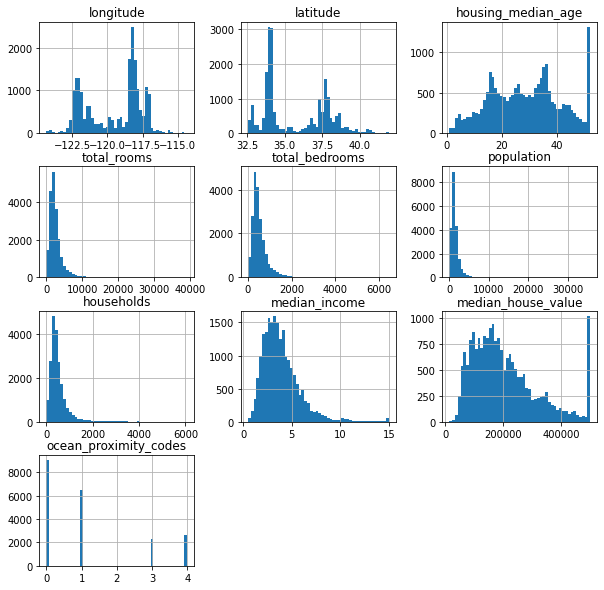

In [13]:
housing.hist(bins=50,figsize=(10,10))

Histograms where skewed too much to a side means the existance of some outliers on the opposite side.

It also worth noting that there is a big lap in the end of the median_house_value and housing_median_age histograms which might be indicating that ancient houses, might worth a lot.

But we need more data to choose some **variables** as the **target** for our regressor to predict these variables for us.

Let's start with some scatter plots:

First convert to fully numerical dataframe:

In [14]:
housing_numerical = housing.drop('ocean_proximity', axis=1)

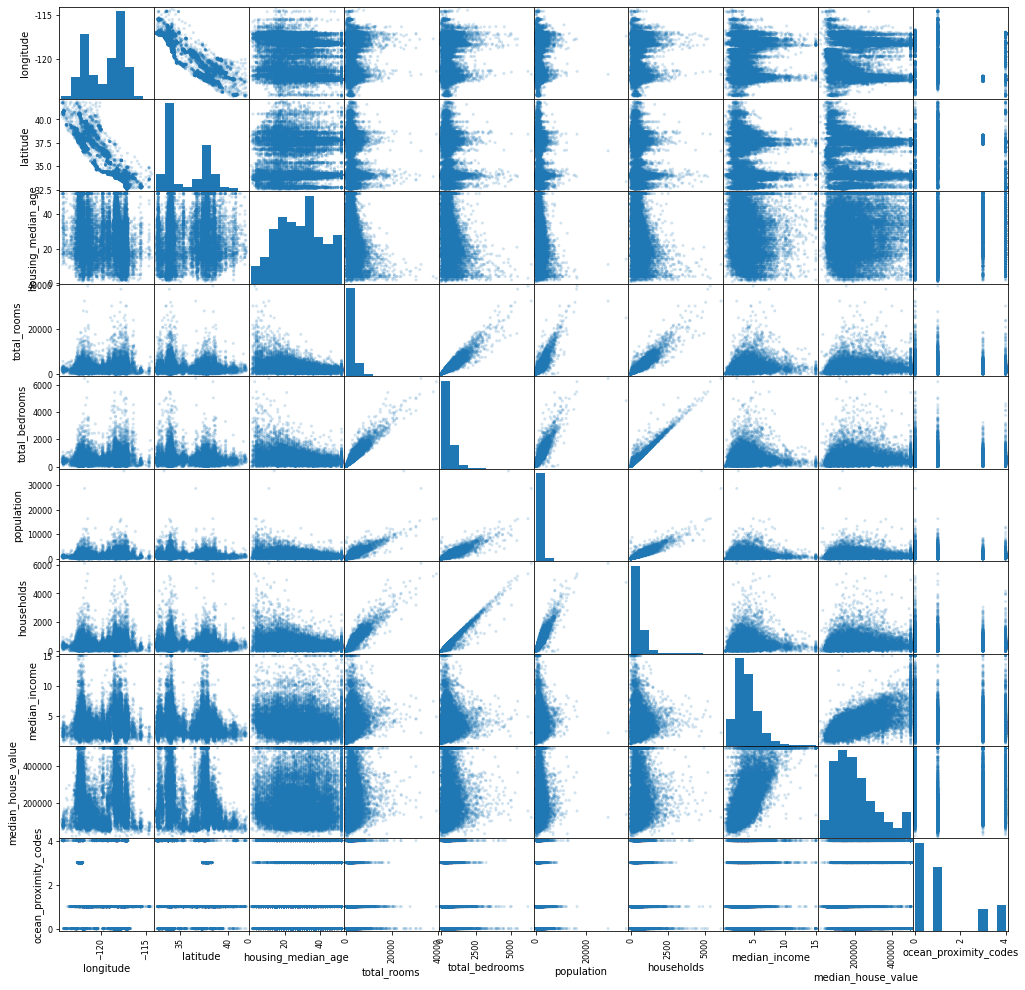

In [15]:
c = pd.plotting.scatter_matrix(housing_numerical, alpha=0.2, figsize=(17, 17))
c;

We can see that there are good realtionships between some of the variables, for example household vs total_bedrooms.
However, this feature is not a very useful one to predict. so we choose median_house_value. It has also an acceptable relationship with the median_income.

First we start splitting the data into variable-target sets:

In [16]:
# Split into variables and targets):
x = housing_numerical.copy().drop('median_house_value', axis=1)
y = housing_numerical.copy().pop('median_house_value')

Then, we split into validation and train sets:

In [17]:
from sklearn.model_selection import train_test_split
x_t, x_v, y_t, y_v = train_test_split(x, y, test_size=0.20, random_state=0)

We need to predict median_house_value from median_incomes:

Creating the model:

In [18]:
def build_model1():
    model = keras.Sequential([
        keras.layers.Dense(64, input_shape=[1,], activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001, clipnorm=1)

    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error',
                         'mean_squared_error'])
    return model

model1 = build_model1()
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 41,729
Trainable params: 41,729
Non-trainable params: 0
_________________________________________________________________


Training:

In [19]:
history = model1.fit(x_t['median_income'], y_t, validation_data=(x_v['median_income'], y_v), epochs=100)

Epoch 1/100
511/511 [==============================] - 2s 4ms/step - loss: 47075250176.0000 - mean_absolute_error: 185083.4844 - mean_squared_error: 47075250176.0000 - val_loss: 19819835392.0000 - val_mean_absolute_error: 108062.5234 - val_mean_squared_error: 19819835392.0000
Epoch 2/100
511/511 [==============================] - 2s 4ms/step - loss: 8171876352.0000 - mean_absolute_error: 65937.0781 - mean_squared_error: 8171876352.0000 - val_loss: 6891868672.0000 - val_mean_absolute_error: 61433.7969 - val_mean_squared_error: 6891868672.0000
Epoch 3/100
511/511 [==============================] - 2s 4ms/step - loss: 7052598784.0000 - mean_absolute_error: 62474.1406 - mean_squared_error: 7052598784.0000 - val_loss: 6886745600.0000 - val_mean_absolute_error: 61695.1914 - val_mean_squared_error: 6886745600.0000
Epoch 4/100
511/511 [==============================] - 2s 4ms/step - loss: 7048893952.0000 - mean_absolute_error: 62639.0195 - mean_squared_error: 7048893952.0000 - val_loss: 691853

Evaluations:

In [20]:
val = model1.evaluate(x_v['median_income'], y_v, verbose=2)

print("Testing: Loss: {:.5f}, Mean Absolute Error: {:.5f}, MSE: {:.5f} for median_house_value".format(val[0],val[1],val[2]))

128/128 - 0s - loss: 6889808384.0000 - mean_absolute_error: 62161.9805 - mean_squared_error: 6889808384.0000
Testing: Loss: 6889808384.00000, Mean Absolute Error: 62161.98047, MSE: 6889808384.00000 for median_house_value


Visualization:

Visualizing the Loss and Accuracy vs epochs:

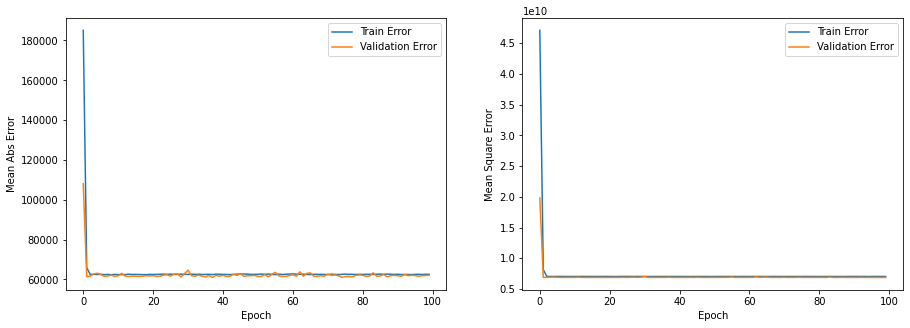

In [21]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    pyplot.figure(figsize=(15,5))

    pyplot.subplot(121)
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Mean Abs Error')
    pyplot.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    pyplot.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Validation Error')
    pyplot.legend()

    pyplot.subplot(122)
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Mean Square Error')
    pyplot.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
    pyplot.plot(hist['epoch'], hist['val_mean_squared_error'], label = 'Validation Error')
    pyplot.legend()
    pyplot.show()


plot_history(history)

Predictions:

In [22]:
test_predictions = model1.predict(x_v['median_income']).flatten()

predicted_loss = np.abs(y.values[0:4]-test_predictions[0:4])/y.describe().transpose()['mean']

# print("Median Income:\n", x['median_income'].values[0:4])
print("\nReal Median House Value:\n", y.values[0:4])
print("\nPredicted Median House Value:\n", test_predictions[0:4])
print("\nLoss:\n", predicted_loss)


Real Median House Value:
 [452600. 358500. 352100. 341300.]

Predicted Median House Value:
 [167396.5  215737.34 148841.06 240890.36]

Loss:
 [1.37898095 0.69026847 0.98277266 0.48548837]


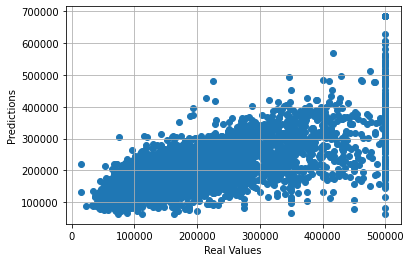

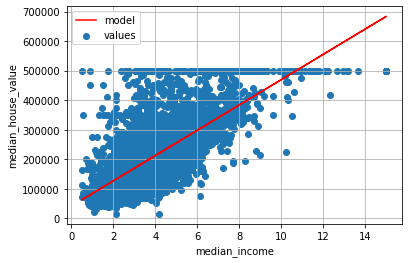

In [23]:
def plot_results(X, Y, Y_predict, plot_name):
    pyplot.figure()
    pyplot.scatter(Y, Y_predict)
    pyplot.grid()
    pyplot.xlabel("Real Values")
    pyplot.ylabel("Predictions")
    pyplot.figure()
    pyplot.scatter(X, Y, label="values")
    pyplot.plot(X, Y_predict, color="red", label="model")
    pyplot.grid()
    pyplot.xlabel("median_income")
    pyplot.ylabel("median_house_value")
    pyplot.legend()

test_predictions = model1.predict(x_v['median_income']).flatten()
plot_results(x_v['median_income'], y_v, test_predictions, "results_nn.png")

Hmmm, not a good linear line, but almost makes it.

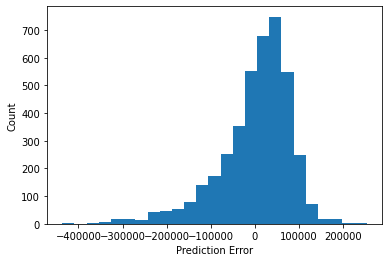

In [24]:
error = test_predictions - y_v
pyplot.hist(error, bins = 25)
pyplot.xlabel("Prediction Error")
_ = pyplot.ylabel("Count")
pyplot.show()

Let's do it agian using another model, and this time we add more layers.

In [25]:
def build_model2():
    model = keras.Sequential()
    model.add(keras.layers.Dense(64, input_shape=[1,], activation="relu"))
    for i in range(5):
        model.add(keras.layers.Dropout(.2))
        model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dense(1))
    
    optimizer = tf.keras.optimizers.RMSprop(0.001, clipnorm=1)

    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error',
                         'mean_squared_error',
                         'mean_squared_logarithmic_error'])
    return model

model2 = build_model2()
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                128       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

In [26]:
history2 = model2.fit(
    x_t['median_income'], y_t,
    validation_data=(x_v['median_income'], y_v),
    verbose=1, epochs=100)

Epoch 1/100
511/511 [==============================] - 3s 6ms/step - loss: 12716650496.0000 - mean_absolute_error: 80322.5547 - mean_squared_error: 12716650496.0000 - mean_squared_logarithmic_error: 4.2818 - val_loss: 6909859840.0000 - val_mean_absolute_error: 62421.6836 - val_mean_squared_error: 6909859840.0000 - val_mean_squared_logarithmic_error: 0.1835
Epoch 2/100
511/511 [==============================] - 3s 6ms/step - loss: 8137567232.0000 - mean_absolute_error: 67212.3359 - mean_squared_error: 8137567232.0000 - mean_squared_logarithmic_error: 0.2007 - val_loss: 6884881920.0000 - val_mean_absolute_error: 62055.6133 - val_mean_squared_error: 6884881920.0000 - val_mean_squared_logarithmic_error: 0.1825
Epoch 3/100
511/511 [==============================] - 3s 5ms/step - loss: 8074862080.0000 - mean_absolute_error: 66978.6484 - mean_squared_error: 8074862080.0000 - mean_squared_logarithmic_error: 0.2015 - val_loss: 7058370560.0000 - val_mean_absolute_error: 60926.1094 - val_mean_squ

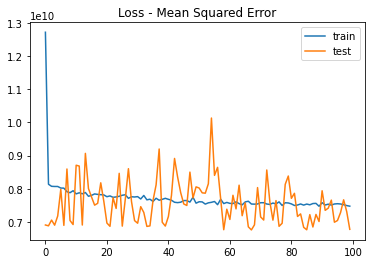

In [27]:
pyplot.title('Loss - Mean Squared Error')
pyplot.plot(history2.history['loss'], label='train')
pyplot.plot(history2.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

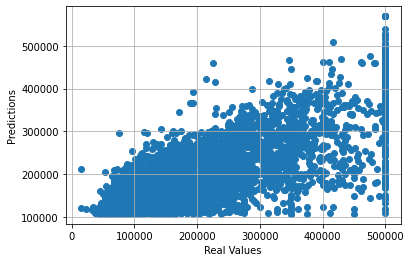

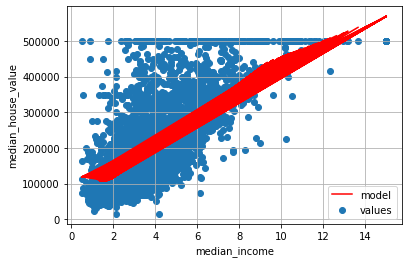

In [34]:
def plot_results(X, Y, Y_predict, plot_name):
    pyplot.figure()
    pyplot.scatter(Y, Y_predict)
    pyplot.grid()
    pyplot.xlabel("Real Values")
    pyplot.ylabel("Predictions")
    pyplot.figure()
    pyplot.scatter(X['median_income'], Y, label="values")
    pyplot.plot(X['median_income'], Y_predict, color="red", label="model")
    pyplot.grid()
    pyplot.xlabel("median_income")
    pyplot.ylabel("median_house_value")
    pyplot.legend()
test_predictions = model2.predict(x_v['median_income']).flatten()
plot_results(x_v, y_v, test_predictions, "results_nn.png")

Compare the results:

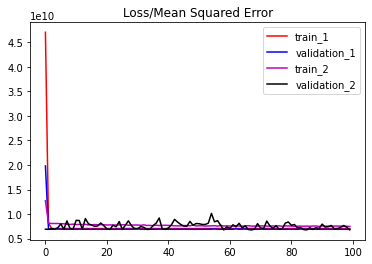

In [29]:
pyplot.title('Loss/Mean Squared Error')
pyplot.plot(history.history['loss'], 'r', label='train_1',)
pyplot.plot(history.history['val_loss'], 'b', label='validation_1')
pyplot.plot(history2.history['loss'], 'm', label='train_2')
pyplot.plot(history2.history['val_loss'], 'k', label='validation_2')
pyplot.legend()
pyplot.show()

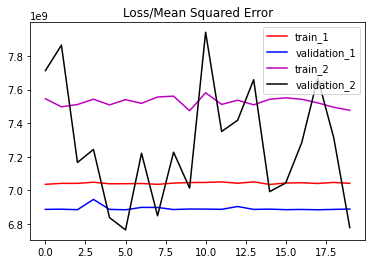

In [32]:
pyplot.title('Loss/Mean Squared Error')
pyplot.plot(history.history['loss'][80:100], 'r', label='train_1',)
pyplot.plot(history.history['val_loss'][80:100], 'b', label='validation_1')
pyplot.plot(history2.history['loss'][80:100], 'm', label='train_2')
pyplot.plot(history2.history['val_loss'][80:100], 'k', label='validation_2')
pyplot.legend()
pyplot.show()

Looks like using multi variable, we have a better model.

Prediction:

In [30]:
test_predictions = model2.predict(x_v['median_income']).flatten()

predicted_loss = np.abs(y_v.values-test_predictions)/y_v.describe().transpose()['mean']

print("\nReal Median House Value:\n", y_v.values[0:4])
print("\nPredicted Median House Value:\n", test_predictions[0:4])
print("\nLoss:\n", predicted_loss[0:4])
print("\nMean Loss:", np.mean(predicted_loss))


Real Median House Value:
 [182600. 201100.  74200. 245000.]

Predicted Median House Value:
 [162016.64 207439.52 139351.72 230666.7 ]

Loss:
 [0.09944669 0.03062881 0.3147748  0.06925006]

Mean Loss: 0.29269888752707485


Plot the difference

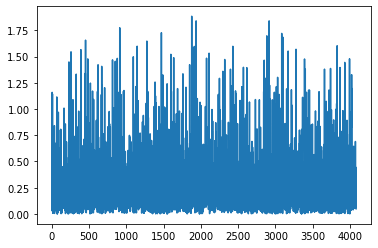

In [31]:
test_predictions = model2.predict(x_v['median_income']).flatten()
pyplot.plot(range(len(predicted_loss)), predicted_loss)